In [1]:
# %% Imports
import numpy as np
import librosa
import matplotlib.pyplot as plt

import model.signal_to_spectrogram as signal_to_spectrogram

import model.data_manipulation
import model.autosimilarity_computation
import model.barwise_input

In [2]:
import nn_fac.multilayer_nmf as mlnmf
import nn_fac.deep_nmf as dnmf
import matplotlib.pyplot as plt

from nn_fac.utils.current_plot import plot_me_this_spectrogram, plot_spec_with_annotations

In [3]:
# %% Audio params
sr = 44100
feature = "nn_log_mel"

In [4]:
# %% General params
eps = 1e-12
plotting = False # If you want data to be plotted

# %% Deep NMF params
all_ranks = [32,8]
n_iter = 500
n_iter_deep = n_iter - 100 # 100 iterations for the initialization using multi-layer NMF

# %% Audio path
audio_path = 'data/Come_Together.wav'
annotations_path = 'data/Come_Together.lab'

# %% Load audio
signal, _ = librosa.load(audio_path, sr=sr, mono=True)

In [5]:
# %% Application to structure estimation
## Process the data, to compute a barwise TF matrix
bars = model.data_manipulation.get_bars_from_audio(audio_path) # Computing the

oversampled_spectrogram = spectrogram = signal_to_spectrogram.get_spectrogram(signal, sr, hop_length=32, feature=feature)
barwise_tf_matrix = model.barwise_input.barwise_TF_matrix(oversampled_spectrogram, bars, 32/sr, subdivision=96) + eps

## Load the annotations
annotations = model.data_manipulation.get_segmentation_from_txt(annotations_path, "MIREX10")
barwise_annotations = model.data_manipulation.segments_from_time_to_bar(annotations, bars)

/opt/anaconda3/lib/python3.11/site-packages/madmom/io/audio.py:643: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


Multi-layer NMF on the Barwise TF Matrix: errors (in beta divergence, layer-wise): [[ 294697.5201691   258385.51063546  234397.43206119  218190.21483614
   206739.73467803  198408.16598189  192199.05387357  187460.87698197
   183758.67966352  180792.6838335   178366.15948876  176336.17980747
   174602.61485907  173085.82039431  171737.152728    170536.19758474
   169451.50123744  168454.69717068  167521.37415009  166626.29891139
   165771.23530451  164947.12222729  164119.92509184  163255.03458802
   162366.30367479  161505.87102611  160694.92763105  159906.99706283
   159108.82590082  158297.366108    157479.43644668  156649.33801922
   155816.23331658  154976.8847424   154125.88838722  153264.98807648
   152386.62599056  151497.10257803  150623.67705096  149785.17782952
   148986.15005208  148221.45896152  147479.83539327  146748.04252519
   146014.28316387  145278.16812933  144546.10822414  143827.63756452
   143131.229072    142459.7987488   141809.13454923  141172.47201918
   1405

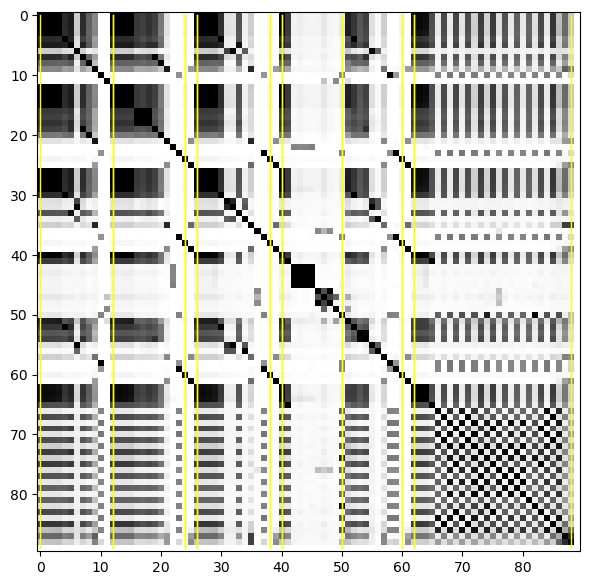

In [6]:
## Apply Multi to the barwise TF matrix
W_multi, H_multi, errors_multi, toc_multi = mlnmf.multilayer_beta_NMF(barwise_tf_matrix, all_ranks = all_ranks, beta = 1, n_iter_max_each_nmf = n_iter, return_errors = True)
print(f"Multi-layer NMF on the Barwise TF Matrix: errors (in beta divergence, layer-wise): {errors_multi}, total time of computation: {np.sum(toc_multi)}.")
as_multi = model.autosimilarity_computation.get_cosine_autosimilarity(W_multi)
plot_spec_with_annotations(as_multi, barwise_annotations)

In [7]:
# Check the constraints on H_l
l = 0
print("Layer 1:", np.sum(H_multi[l], axis=1))
l = 1
print("Layer 2:", np.sum(H_multi[l], axis=1))

Layer 1: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Layer 2: [1. 1. 1. 1. 1. 1. 1. 1.]


Deep NMF on the Barwise TF Matrix: errors per itaration (in relative beta-divergence, compared to the init): [[1.22178607e+05 1.07035929e+00 1.10666801e+00 ... 1.11043761e+00
  1.11042445e+00 1.11041146e+00]
 [5.23656070e+05 6.96730531e-01 5.70563490e-01 ... 2.34231496e-01
  2.34234716e-01 2.34237851e-01]], time of computation after the init: 35.84788393974304.


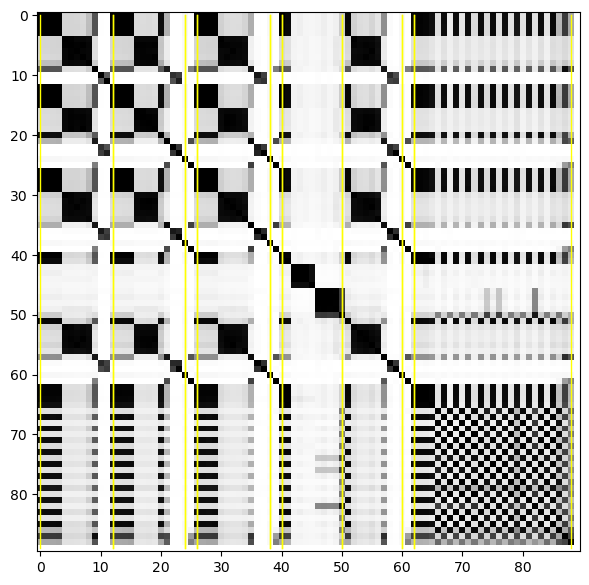

In [8]:
## Apply Deep NMF to the barwise TF matrix
W_deep, H_deep, errors_deep, toc_deep = dnmf.deep_KL_NMF(barwise_tf_matrix, all_ranks = all_ranks, n_iter_max_each_nmf = 100, n_iter_max_deep_loop = n_iter_deep+200,return_errors=True)
print(f"Deep NMF on the Barwise TF Matrix: errors per itaration (in relative beta-divergence, compared to the init): {errors_deep}, time of computation after the init: {np.sum(toc_deep)}.")
as_deep = model.autosimilarity_computation.get_cosine_autosimilarity(W_deep)
plot_spec_with_annotations(as_deep, barwise_annotations)

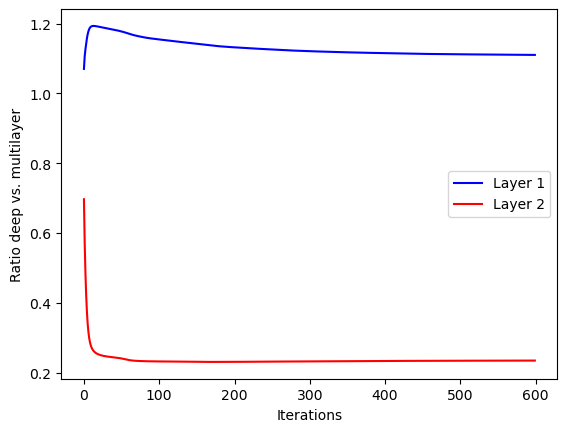

In [9]:
# Evolution of the erros at the different levels of 
# deep β-NMF with β = 1 (initialized with multilayer β-NMF after 250 iterations) 
# divided by the error of multilayer β-NMF after 500 iterations.
plt.figure(1)
plt.plot(errors_deep[0,1:], color='blue', label='Layer 1')
plt.plot(errors_deep[1,1:], color='red', label='Layer 2')
plt.xlabel('Iterations')
plt.ylabel('Ratio deep vs. multilayer')
# plt.title(r'Computation $x^\star$')
plt.legend()
plt.show()

In [10]:
# Check the constraints on H_l
l = 0
print("Layer 1:", np.sum(H_deep[l], axis=1))
l = 1
print("Layer 2:", np.sum(H_deep[l], axis=1))

Layer 1: [1.         1.         0.99999999 0.99999999 0.99999999 0.99999998
 1.00000002 1.00000001 1.00000002 0.99999999 0.99999999 0.99999999
 0.99999999 0.99999999 1.         1.00000002 1.00000001 1.00000001
 1.         1.00000001 0.99999999 1.         1.00000001 0.99999998
 0.99999999 1.         0.99999998 0.99999999 1.00000001 1.
 1.00000001 1.        ]
Layer 2: [1. 1. 1. 1. 1. 1. 1. 1.]
